In [39]:
import os
import numpy as np
import pandas as pd

import cartopy.crs as ccrs

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from shapely.wkt import loads
from shapely.geometry import Polygon, MultiPolygon

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [40]:
dir_in = '../input/filter_cluster.csv'

In [41]:
DATA = pd.read_csv(dir_in)

x_p = []
y_p = []
lat_c = []
lon_c = []
geo = []
area = []
for nn in np.arange(0,len(DATA)-1,1):
    wkt_polygon = DATA['geometry'][nn]
    polygon = loads(wkt_polygon)

    if isinstance(polygon, Polygon):
        x, y = polygon.exterior.xy
        if len(x) > 10:
            lat_c.append(polygon.centroid.xy[1][0])
            lon_c.append(polygon.centroid.xy[0][0])
            x_p.append(x)
            y_p.append(y)
            geo.append(DATA['geometry'][nn])
            area.append(polygon.area)

    elif isinstance(polygon, MultiPolygon):
        largest_polygon = None
        max_area = 0
        for PO in polygon.geoms:
            if PO.area > max_area:
                max_area = PO.area
                largest_polygon = PO
            x, y = largest_polygon.exterior.xy
            if len(x) > 10:
                lat_c.append(largest_polygon.centroid.xy[1][0])
                lon_c.append(largest_polygon.centroid.xy[0][0])
                x_p.append(x)
                y_p.append(y)
                geo.append(largest_polygon.wkt)
                area.append(largest_polygon.area)

    else:
        print("Geometría no reconocida")

In [42]:
DATA = pd.DataFrame({'x_p':x_p, 'y_p':y_p, 'lat_c':lat_c, 'area':area, 'lon_c':lon_c, 'geometry':geo})
DATA = DATA[DATA['area']>=3].reset_index(drop=True)

DATA_TRAINING = DATA.iloc[:116]
DATA_VALIDATION = DATA.iloc[116:]

print(len(DATA_TRAINING))
print(len(DATA_VALIDATION))

116
7


In [43]:
# for nn in range(len(DATA)):
#     polygon = loads(DATA['geometry'][nn])
#     x, y = polygon.exterior.xy  # Obtener coordenadas del contorno exterior
#     proj = ccrs.PlateCarree()
#     fig = plt.figure(figsize=(3,3),dpi=300)
#     gs = gridspec.GridSpec(1,1)
#     ax1 = plt.subplot(gs[0, 0], projection = proj)
#     ax1.set_extent([-95, -75, 19, 33],crs=proj)
#     ax1.plot(x, y, linewidth=0.4)  # Ploteo con eti
#     ax1.set_title(f'Time: {nn}',loc='left',fontsize=6)
#     ax1.set_title(np.round(DATA['area'].values[nn],2),loc='right',fontsize=6)
#     fig_out = f'../../output/figures/GEO_{str(nn).zfill(3)}'
#     plt.savefig(fig_out, facecolor='white',bbox_inches ='tight',pad_inches = 0.1)
#     plt.close()

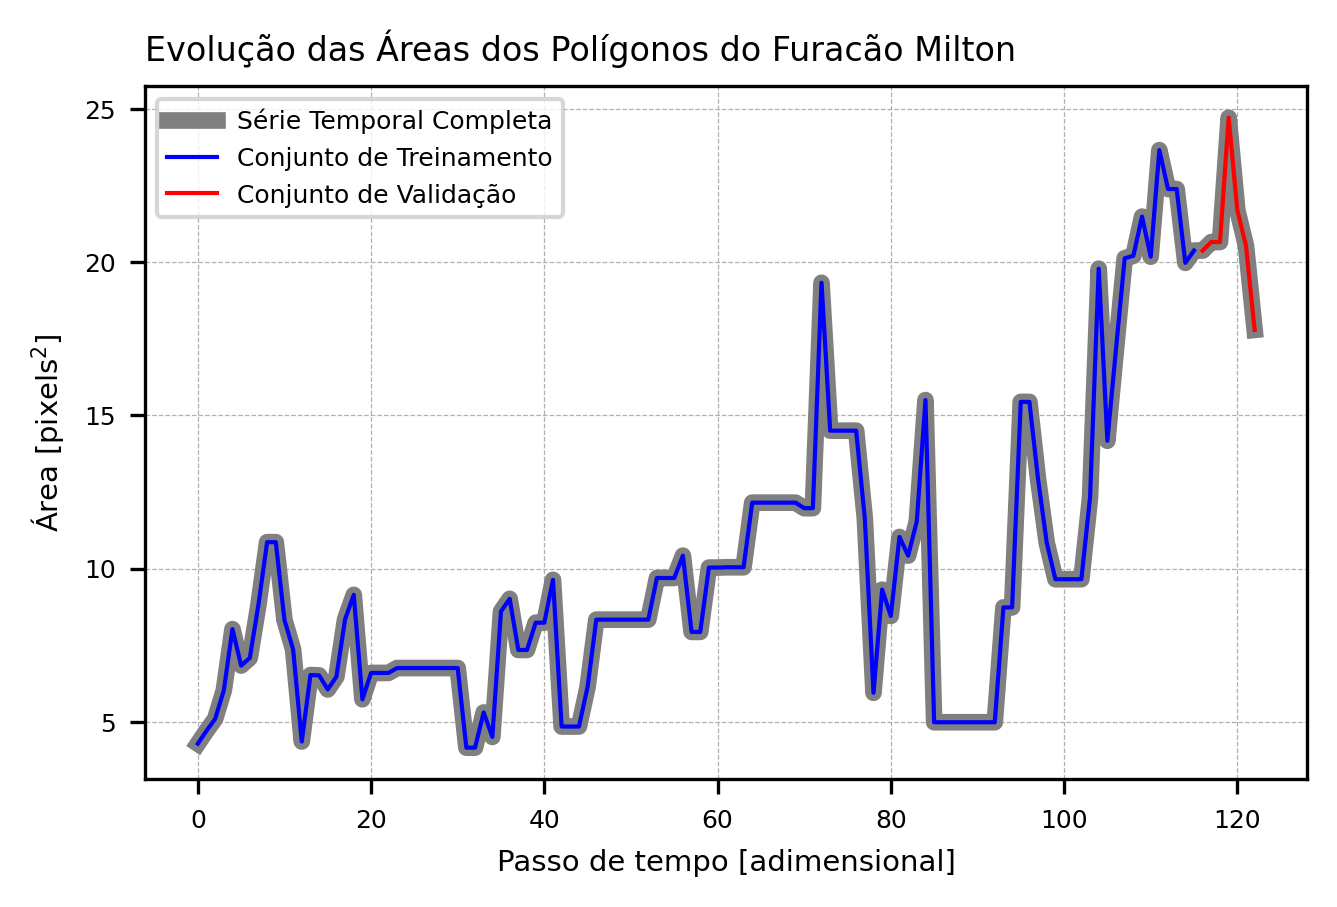

In [44]:
fig = plt.figure(figsize=(5,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(DATA['area'], c='gray', linewidth=4, label='Série Temporal Completa')
ax1.plot(DATA_TRAINING['area'], c='b', linewidth=1, label='Conjunto de Treinamento')
ax1.plot(DATA_VALIDATION['area'], c='r', linewidth=1, label='Conjunto de Validação')

ax1.set_title('Evolução das Áreas dos Polígonos do Furacão Milton',fontsize=8,loc='left')
ax1.set_ylabel(r'Área [pixels$^2$]', fontsize=7)
ax1.set_xlabel('Passo de tempo [adimensional]', fontsize=7)

plt.grid(linewidth=0.3,linestyle='--')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.legend(fontsize=6)

fig_out = f'../fig/GEO_Areas_time.png'
plt.savefig(fig_out, facecolor='white',bbox_inches ='tight',pad_inches = 0.1)

In [59]:
DATA_VALIDATION = DATA_VALIDATION.reset_index(drop=True)

In [63]:
len(DATA_TRAINING)

116

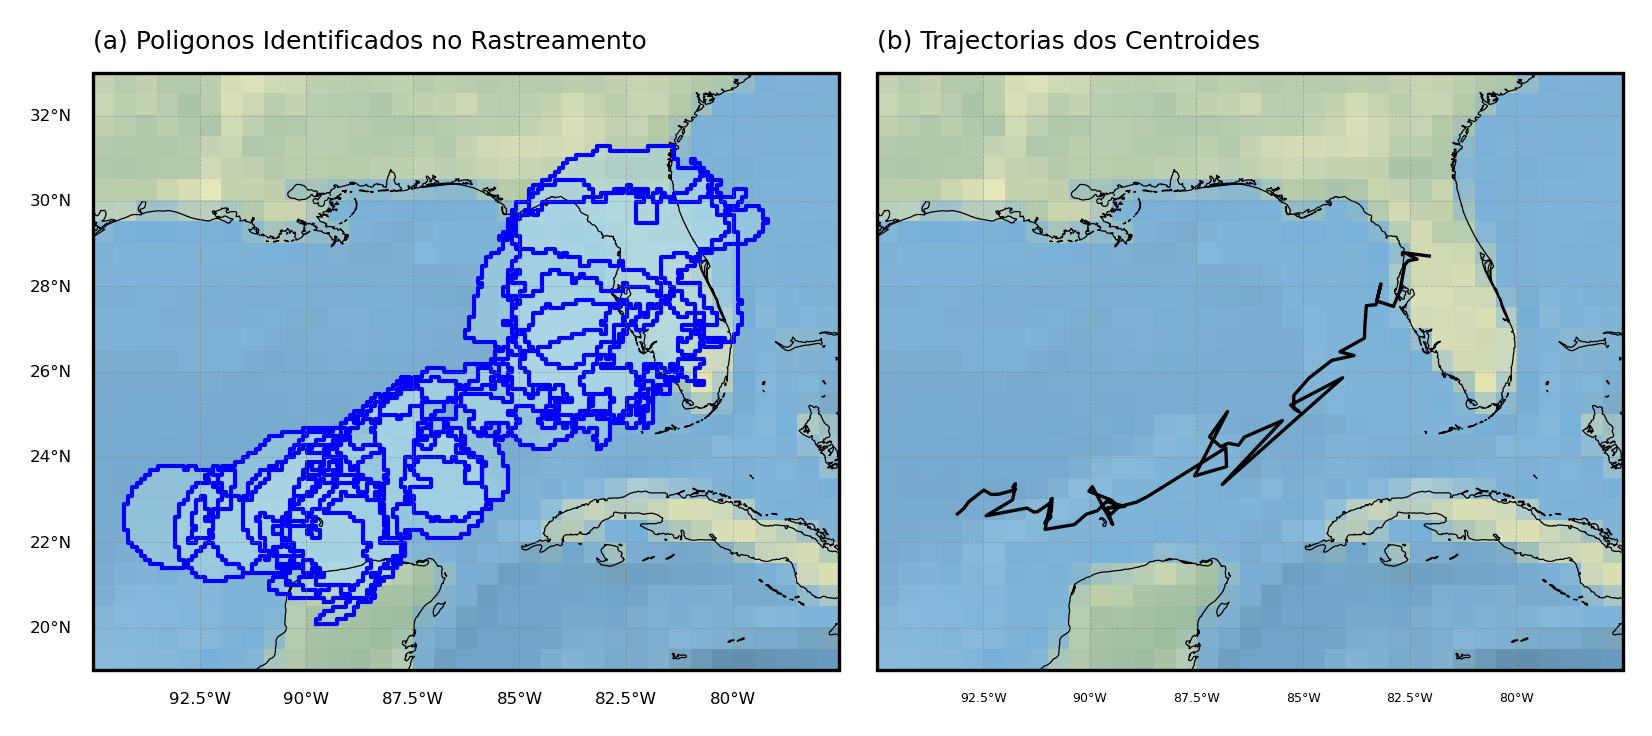

In [83]:
cmap = matplotlib.colormaps.get_cmap('YlGn')
cmap = matplotlib.colormaps.get_cmap('coolwarm')
cmap = matplotlib.colormaps.get_cmap('Spectral_r')

norm = plt.Normalize(vmin=0, vmax=len(DATA)-1)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.coastlines(linewidth=0.3)
ax1.set_extent([-95, -77.5, 19, 33],crs=proj)
ax1.stock_img()

for nn in np.arange(0,len(DATA_TRAINING),2):
    if nn%14 == 0:
        polygon = loads(DATA_TRAINING['geometry'][nn])
        x, y = polygon.exterior.xy
        ax1.plot(x, y, color='blue', linewidth=1)
        plt.fill(x, y, color='lightblue', alpha=0.5)

for nn in range(len(DATA_VALIDATION)):
    if nn%5 == 0:
        polygon = loads(DATA_VALIDATION['geometry'][nn])
        x, y = polygon.exterior.xy
        ax1.plot(x, y, color='blue', linewidth=1)
        plt.fill(x, y, color='lightblue', alpha=0.5)

ax1.set_title('(a) Poligonos Identificados no Rastreamento', fontsize=6,loc='left')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

# ==================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.coastlines(linewidth=0.3)
ax1.set_extent([-95, -77.5, 19, 33],crs=proj)
ax1.stock_img()

# for nn in range(0,len(DATA)-1):
#     if nn%10 == 0:
#         color = cmap(norm(nn))
        # ax1.annotate(str(nn), (DATA['lon_c'][nn], DATA['lat_c'][nn]), color=color, fontsize=6, ha='center', va='center', zorder=6)

ax1.plot(DATA_TRAINING['lon_c'], DATA_TRAINING['lat_c'], linewidth=0.8, color='k', zorder=5)
ax1.plot(DATA_VALIDATION['lon_c'], DATA_VALIDATION['lat_c'], linewidth=0.8, color='k', zorder=5)

# cbar_ax = fig.add_axes([0.965, 0.168, 0.025, 0.664])
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax1, cax=cbar_ax)
# cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) Trajectorias dos Centroides', fontsize=6,loc='left')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.grid(linestyle='--', linewidth=0.3)

# ==================================================================================
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.05, wspace=0.05)

fig_out = f'../fig/Positions_time.png'                                                                                                                                                            
plt.savefig(fig_out, facecolor='white',bbox_inches ='tight',pad_inches = 0.1)

In [47]:
# Datos de ejemplo (reemplaza con tus datos reales)
POS = pd.DataFrame({'x':np.array(DATA_TRAINING['lon_c']), 'y':np.array(DATA_TRAINING['lat_c'])})
POS = POS.sort_values(by='x', ascending=True)

# Ajuste de regresión lineal
model_linear = LinearRegression()
model_linear.fit(POS['x'].values.reshape(-1, 1), POS['y'].values)
y_pred_linear = model_linear.predict(POS['x'].values.reshape(-1, 1))

# Ajuste de regresión cuadrática
poly_quadratic = PolynomialFeatures(degree=2)
x_quad = poly_quadratic.fit_transform(POS['x'].values.reshape(-1, 1))
model_quadratic = LinearRegression()
model_quadratic.fit(x_quad, POS['y'].values)
y_pred_quadratic = model_quadratic.predict(x_quad)

# Ajuste de regresión cúbica
poly_cubic = PolynomialFeatures(degree=3)
x_cubic = poly_cubic.fit_transform(POS['x'].values.reshape(-1, 1))
model_cubic = LinearRegression()
model_cubic.fit(x_cubic, POS['y'].values)
y_pred_cubic = model_cubic.predict(x_cubic)

# Cálculo de la incertidumbre (desviación estándar de los residuos)
std_linear = np.std(POS['y'].values - y_pred_linear)
std_quadratic = np.std(POS['y'].values - y_pred_quadratic)
std_cubic = np.std(POS['y'].values - y_pred_cubic)

#Tiempos futuros
future = np.arange(POS['x'].values[-1],-81,0.5)

y_pred_future_linear = model_linear.predict(future.reshape(-1, 1))

x_future_quad = poly_quadratic.fit_transform(future.reshape(-1, 1))
y_pred_future_quad = model_quadratic.predict(x_future_quad)

x_future_cubic = poly_cubic.transform(future.reshape(-1, 1))
y_pred_future_cubic = model_cubic.predict(x_future_cubic)

In [48]:
len(y_pred_linear), len(POS['x'].values)

(116, 116)

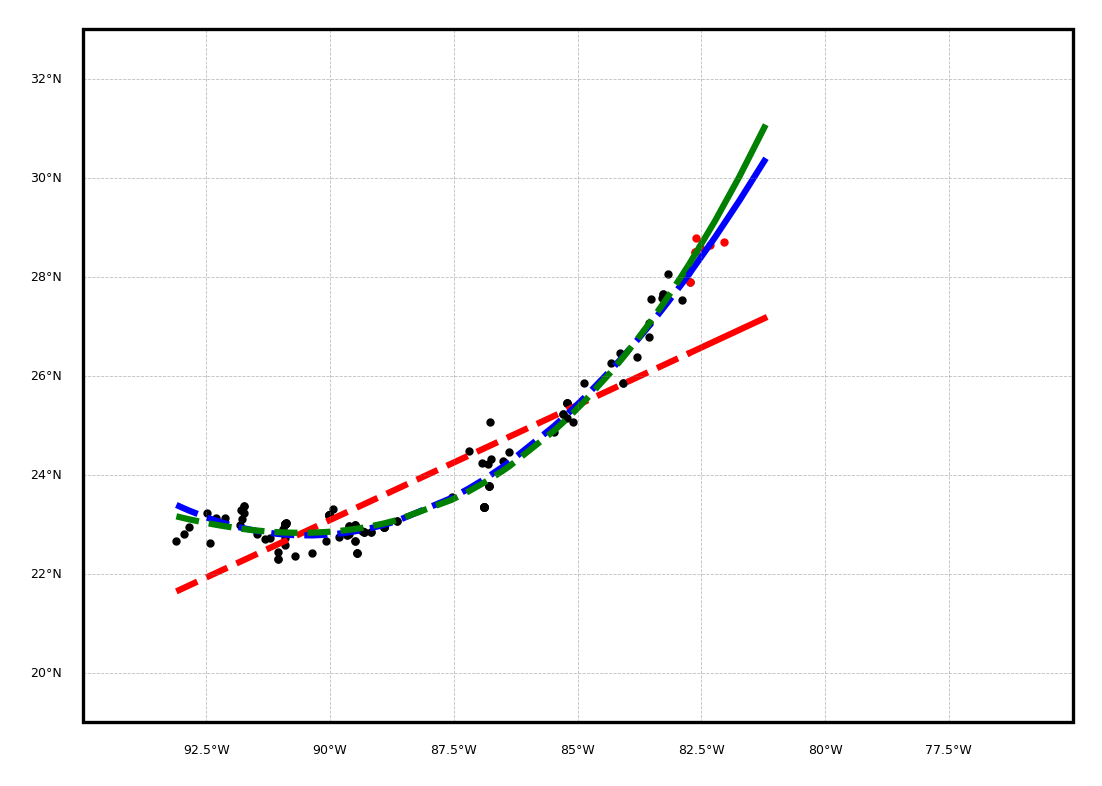

In [49]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([-95, -75, 19, 33],crs=proj)
ax1.scatter(DATA_TRAINING['lon_c'], DATA_TRAINING['lat_c'], s=1, c='k')
ax1.scatter(DATA_VALIDATION['lon_c'], DATA_VALIDATION['lat_c'], s=1, c='r')

ax1.plot(POS['x'].values,y_pred_linear,linestyle='--',color='r')
ax1.plot(POS['x'].values,y_pred_quadratic,linestyle='--',color='b')
ax1.plot(POS['x'].values,y_pred_cubic,linestyle='--',color='g')

ax1.plot(future,y_pred_future_linear,linestyle='-',color='r')
ax1.plot(future,y_pred_future_quad,linestyle='-',color='b')
ax1.plot(future,y_pred_future_cubic,linestyle='-',color='g')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

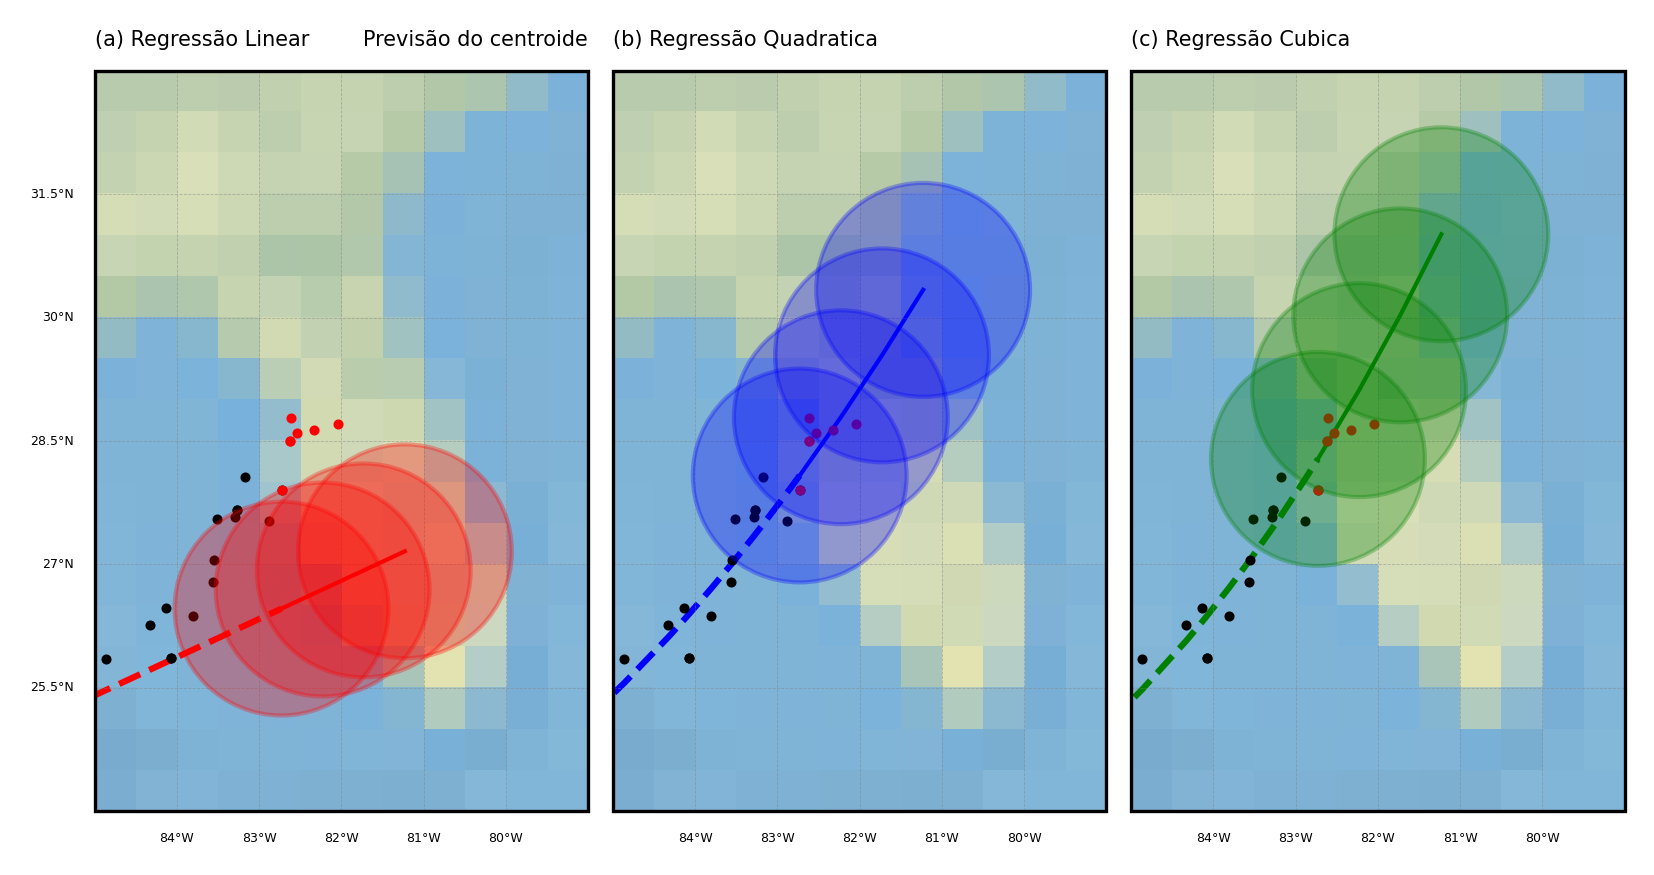

In [50]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([-85, -79, 24, 33],crs=proj)
ax1.stock_img()

ax1.scatter(DATA_TRAINING['lon_c'].values, DATA_TRAINING['lat_c'].values, color='k', s=2, label='Centroides de Treinamento', zorder=5)
ax1.scatter(DATA_VALIDATION['lon_c'].values, DATA_VALIDATION['lat_c'].values, color='r', s=2, label='Centroides de Validação', zorder=5)

ax1.plot(future,y_pred_future_linear, linewidth=1, color='r')
ax1.plot(POS['x'].values,y_pred_linear,linestyle='--',color='r')

for nn in range(len(future)):
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_linear[nn]), radius=1.3, color='r', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title('(a) Regressão Linear', loc='left', fontsize=5)
ax1.set_title('Previsão do centroide',loc='right',fontsize=5)

# ==================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([-85, -79, 24, 33],crs=proj)
ax1.stock_img()

ax1.scatter(DATA_TRAINING['lon_c'].values, DATA_TRAINING['lat_c'].values, color='k', s=2, label='Centroides de Treinamento', zorder=5)
ax1.scatter(DATA_VALIDATION['lon_c'].values, DATA_VALIDATION['lat_c'].values, color='r', s=2, label='Centroides de Validação', zorder=5)

ax1.plot(future,y_pred_future_quad, linewidth=1, color='b')
ax1.plot(POS['x'].values,y_pred_quadratic,linestyle='--',color='b')

for nn in range(len(future)):
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_quad[nn]), radius=1.3, color='b', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title('(b) Regressão Quadratica', loc='left', fontsize=5)

# ==================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([-85, -79, 24, 33],crs=proj)
ax1.stock_img()

ax1.scatter(DATA_TRAINING['lon_c'].values, DATA_TRAINING['lat_c'].values, color='k', s=2, label='Centroides de Treinamento', zorder=5)
ax1.scatter(DATA_VALIDATION['lon_c'].values, DATA_VALIDATION['lat_c'].values, color='r', s=2, label='Centroides de Validação', zorder=5)

ax1.plot(future,y_pred_future_cubic, linewidth=1, color='g')
ax1.plot(POS['x'].values,y_pred_cubic,linestyle='--',color='g')

for nn in range(len(future)):
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_cubic[nn]), radius=1.3, color='g', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title('(c) Regressão Cubica', loc='left', fontsize=5)

# ==================================================================================
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.05, wspace=0.05)

fig_out = f'../fig/Previsao_1.png'
plt.savefig(fig_out, facecolor='white',bbox_inches ='tight',pad_inches = 0.1)

In [51]:
# Asumimos que DATA es tu DataFrame y tiene una columna 'area' con la serie de tiempo.
# Crear el índice de tiempo como variable independiente (puede ser un índice de 1 a n)
X = np.array(range(len(DATA['area']))).reshape(-1, 1)  # Indices como variable independiente
y = DATA['area'].values  # Serie de áreas como variable dependiente

# Crear los nuevos tiempos futuros (121 a 130)
X_future = np.array(range(len(X), len(X)+4)).reshape(-1, 1)

# Creación de un modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X, y)
y_RATIO_linear = linear_model.predict(X)

# Creación de un modelo de regresión cuadrática
poly_quad = PolynomialFeatures(degree=2)
X_poly_quad = poly_quad.fit_transform(X)
quad_model = LinearRegression()
quad_model.fit(X_poly_quad, y)
y_RATIO_quad = quad_model.predict(X_poly_quad)

# Creación de un modelo de regresión cúbica
poly_cubic = PolynomialFeatures(degree=3)
X_poly_cubic = poly_cubic.fit_transform(X)
cubic_model = LinearRegression()
cubic_model.fit(X_poly_cubic, y)
y_RATIO_cubic = cubic_model.predict(X_poly_cubic)

# Creación de los modelos de regresión de 5° orden
poly_5 = PolynomialFeatures(degree=5)
X_poly_5 = poly_5.fit_transform(X)
model_5 = LinearRegression()
model_5.fit(X_poly_5, y)

# Creación de los modelos de regresión 6° orden
poly_6 = PolynomialFeatures(degree=6)
X_poly_6 = poly_6.fit_transform(X)
model_6 = LinearRegression()
model_6.fit(X_poly_6, y)

y_RATIO_linear_future = linear_model.predict(X_future)
y_RATIO_quad_future = quad_model.predict(poly_quad.transform(X_future))
y_RATIO_cubic_future = cubic_model.predict(poly_cubic.transform(X_future))
y_RATIO_5_future = model_5.predict(poly_5.transform(X_future))
y_RATIO_6_future = model_6.predict(poly_6.transform(X_future))

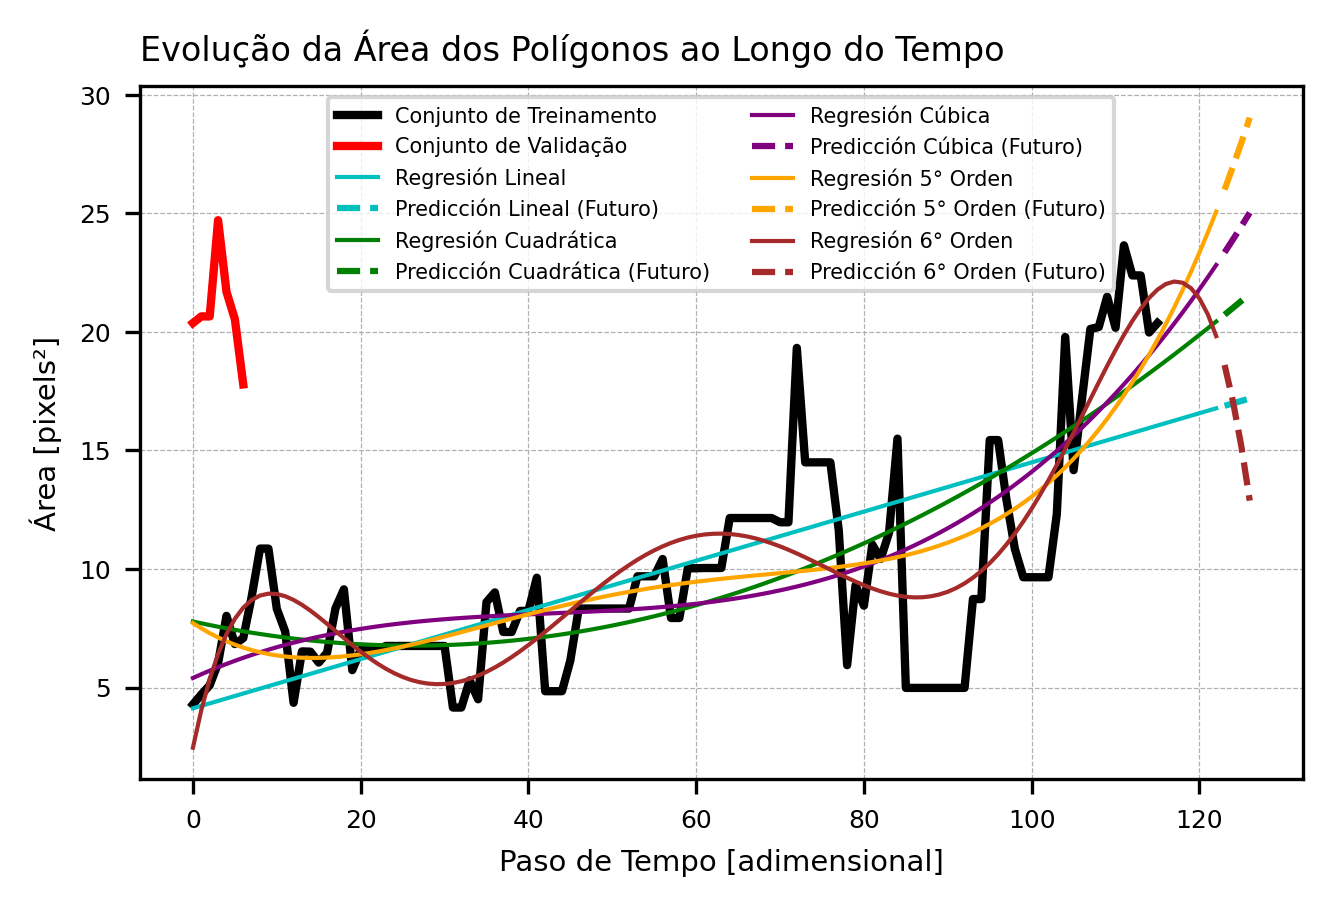

In [52]:
fig = plt.figure(figsize=(5,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
# ax1.plot(DATA['area'], c='k', linewidth=2, label='Série Temporal Completa')
ax1.plot(DATA_TRAINING['area'], c='k', linewidth=2, label='Conjunto de Treinamento')
ax1.plot(DATA_VALIDATION['area'], c='r', linewidth=2, label='Conjunto de Validação')

# # Graficar las predicciones para los tiempos históricos
ax1.plot(X, linear_model.predict(X), linewidth=1, color='c', label='Regresión Lineal')
ax1.plot(X_future, y_RATIO_linear_future, color='c', linestyle='--', label='Predicción Lineal (Futuro)')

ax1.plot(X, quad_model.predict(X_poly_quad), linewidth=1, color='green', label='Regresión Cuadrática')
ax1.plot(X_future, y_RATIO_quad_future, color='green', linestyle='--', label='Predicción Cuadrática (Futuro)')

ax1.plot(X, cubic_model.predict(X_poly_cubic), linewidth=1, color='purple', label='Regresión Cúbica')
ax1.plot(X_future, y_RATIO_cubic_future, color='purple', linestyle='--', label='Predicción Cúbica (Futuro)')

ax1.plot(X, model_5.predict(X_poly_5), linewidth=1, color='orange', label='Regresión 5° Orden')
ax1.plot(X_future, y_RATIO_5_future, color='orange', linestyle='--', label='Predicción 5° Orden (Futuro)')

ax1.plot(X, model_6.predict(X_poly_6), linewidth=1, color='brown', label='Regresión 6° Orden')
ax1.plot(X_future, y_RATIO_6_future, color='brown', linestyle='--', label='Predicción 6° Orden (Futuro)')

ax1.set_title('Evolução da Área dos Polígonos ao Longo do Tempo',loc='left',fontsize=8)
plt.xlabel('Paso de Tempo [adimensional]', fontsize=7)
plt.ylabel('Área [pixels²]', fontsize=7)
plt.grid(linewidth=0.3,linestyle='--')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.legend(fontsize=5,ncols=2)

fig_out = f'../fig/Previsao_area.png'
# plt.savefig(fig_out, facecolor='white',bbox_inches ='tight',pad_inches = 0.1)

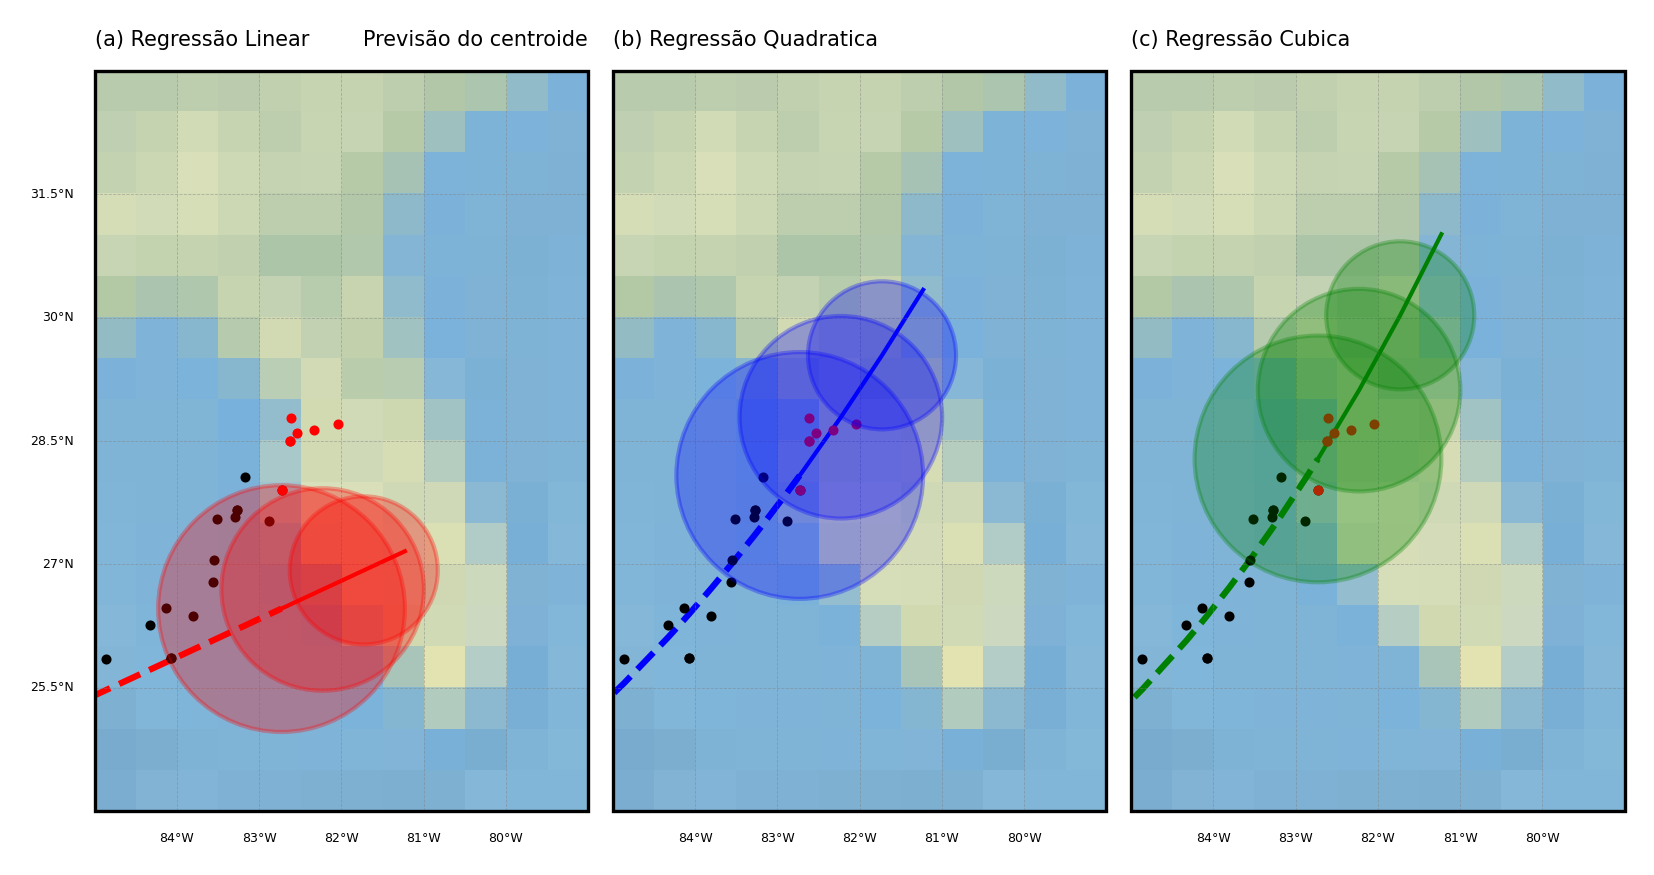

In [53]:
RATIO_3 = (y_RATIO_cubic_future-np.min(y_RATIO_cubic_future))/(np.max(y_RATIO_cubic_future)-np.min(y_RATIO_cubic_future))+0.5
RATIO_6 = (y_RATIO_6_future-np.min(y_RATIO_6_future))/(np.max(y_RATIO_6_future)-np.min(y_RATIO_6_future))+0.5

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([-85, -79, 24, 33],crs=proj)
ax1.stock_img()

ax1.scatter(DATA_TRAINING['lon_c'].values, DATA_TRAINING['lat_c'].values, color='k', s=2, label='Centroides de Treinamento', zorder=5)
ax1.scatter(DATA_VALIDATION['lon_c'].values, DATA_VALIDATION['lat_c'].values, color='r', s=2, label='Centroides de Validação', zorder=5)

ax1.plot(future,y_pred_future_linear, linewidth=1, color='r')
ax1.plot(POS['x'].values,y_pred_linear,linestyle='--',color='r')

for nn in range(len(future)-1):
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_linear[nn]), radius=RATIO_6[nn], color='r', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title('(a) Regressão Linear', loc='left', fontsize=5)
ax1.set_title('Previsão do centroide',loc='right',fontsize=5)

# ==================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([-85, -79, 24, 33],crs=proj)
ax1.stock_img()

ax1.scatter(DATA_TRAINING['lon_c'].values, DATA_TRAINING['lat_c'].values, color='k', s=2, label='Centroides de Treinamento', zorder=5)
ax1.scatter(DATA_VALIDATION['lon_c'].values, DATA_VALIDATION['lat_c'].values, color='r', s=2, label='Centroides de Validação', zorder=5)

ax1.plot(future,y_pred_future_quad, linewidth=1, color='b')
ax1.plot(POS['x'].values,y_pred_quadratic,linestyle='--',color='b')

for nn in range(len(future)-1):
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_quad[nn]), radius=RATIO_6[nn], color='b', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title('(b) Regressão Quadratica', loc='left', fontsize=5)

# ==================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([-85, -79, 24, 33],crs=proj)
ax1.stock_img()

ax1.scatter(DATA_TRAINING['lon_c'].values, DATA_TRAINING['lat_c'].values, color='k', s=2, label='Centroides de Treinamento', zorder=5)
ax1.scatter(DATA_VALIDATION['lon_c'].values, DATA_VALIDATION['lat_c'].values, color='r', s=2, label='Centroides de Validação', zorder=5)

ax1.plot(future,y_pred_future_cubic, linewidth=1, color='g')
ax1.plot(POS['x'].values,y_pred_cubic,linestyle='--',color='g')

for nn in range(len(future)-1):
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_cubic[nn]), radius=RATIO_6[nn], color='g', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title('(c) Regressão Cubica', loc='left', fontsize=5)

# ==================================================================================
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.05, wspace=0.05)

fig_out = f'../fig/Previsao_area_ratio.png'
plt.savefig(fig_out, facecolor='white',bbox_inches ='tight',pad_inches = 0.1)

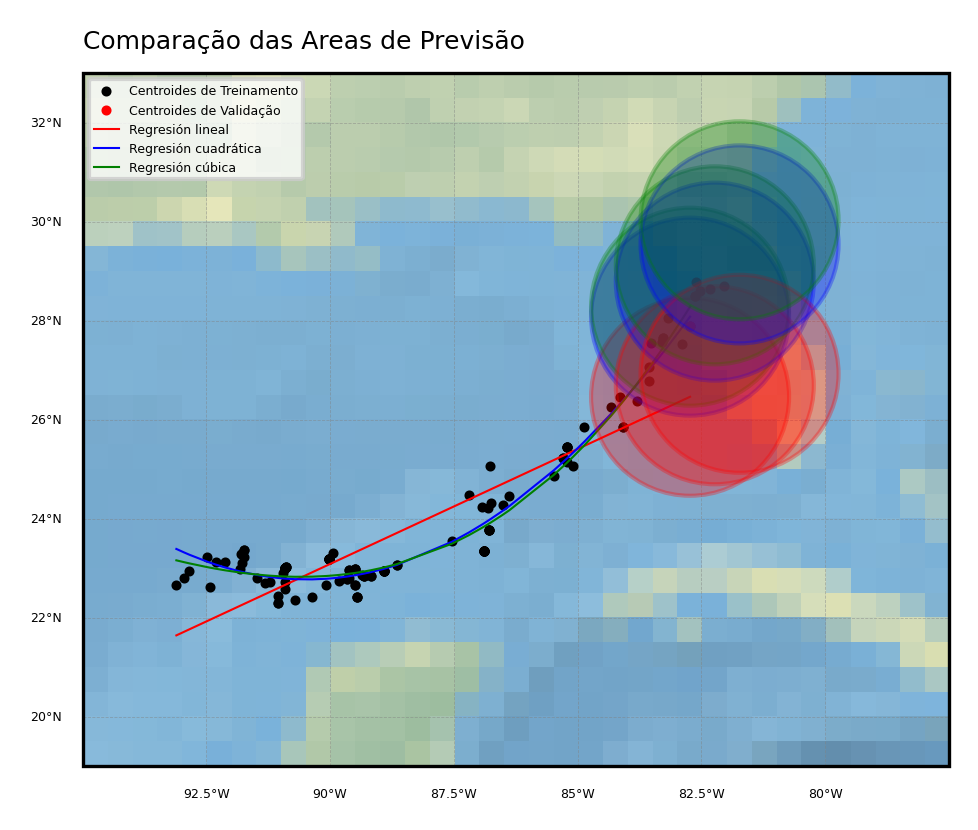

In [54]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([-95, -77.5, 19, 33],crs=proj)
ax1.stock_img()

ax1.scatter(DATA_TRAINING['lon_c'].values, DATA_TRAINING['lat_c'].values, color='k', s=2, label='Centroides de Treinamento', zorder=5)
ax1.scatter(DATA_VALIDATION['lon_c'].values, DATA_VALIDATION['lat_c'].values, color='r', s=2, label='Centroides de Validação', zorder=5)

for nn in range(len(future)-1):
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_linear[nn]), radius=2, color='r', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_quad[nn]), radius=2, color='b', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_cubic[nn]), radius=2, color='g', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))


ax1.plot(POS['x'].values, y_pred_linear, linewidth=0.5, color='r', label='Regresión lineal', zorder=6)
ax1.plot(POS['x'].values, y_pred_quadratic, linewidth=0.5, color='b', label='Regresión cuadrática', zorder=6)
ax1.plot(POS['x'].values, y_pred_cubic, linewidth=0.5, color='g', label='Regresión cúbica', zorder=6)


gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.legend(fontsize=3)

ax1.set_title('Comparação das Areas de Previsão', fontsize=6,loc='left')

fig_out = f'../fig/Diferenças.png'
# plt.savefig(fig_out, facecolor='white',bbox_inches ='tight',pad_inches = 0.1)

In [55]:
# Datos de ejemplo (reemplaza con tus datos reales)
POS = pd.DataFrame({'x':np.array(DATA_TRAINING['lon_c']), 'y':np.array(DATA_TRAINING['lat_c'])})
POS = POS.sort_values(by='x', ascending=True)

# Ajuste de regresión lineal
model_linear = LinearRegression()
model_linear.fit(POS['x'].values.reshape(-1, 1), POS['y'].values)
y_pred_linear = model_linear.predict(POS['x'].values.reshape(-1, 1))

# Ajuste de regresión cuadrática
poly_quadratic = PolynomialFeatures(degree=2)
x_quad = poly_quadratic.fit_transform(POS['x'].values.reshape(-1, 1))
model_quadratic = LinearRegression()
model_quadratic.fit(x_quad, POS['y'].values)
y_pred_quadratic = model_quadratic.predict(x_quad)

# Ajuste de regresión cúbica
poly_cubic = PolynomialFeatures(degree=3)
x_cubic = poly_cubic.fit_transform(POS['x'].values.reshape(-1, 1))
model_cubic = LinearRegression()
model_cubic.fit(x_cubic, POS['y'].values)
y_pred_cubic = model_cubic.predict(x_cubic)

# Cálculo de la incertidumbre (desviación estándar de los residuos)
std_linear = np.std(POS['y'].values - y_pred_linear)
std_quadratic = np.std(POS['y'].values - y_pred_quadratic)
std_cubic = np.std(POS['y'].values - y_pred_cubic)

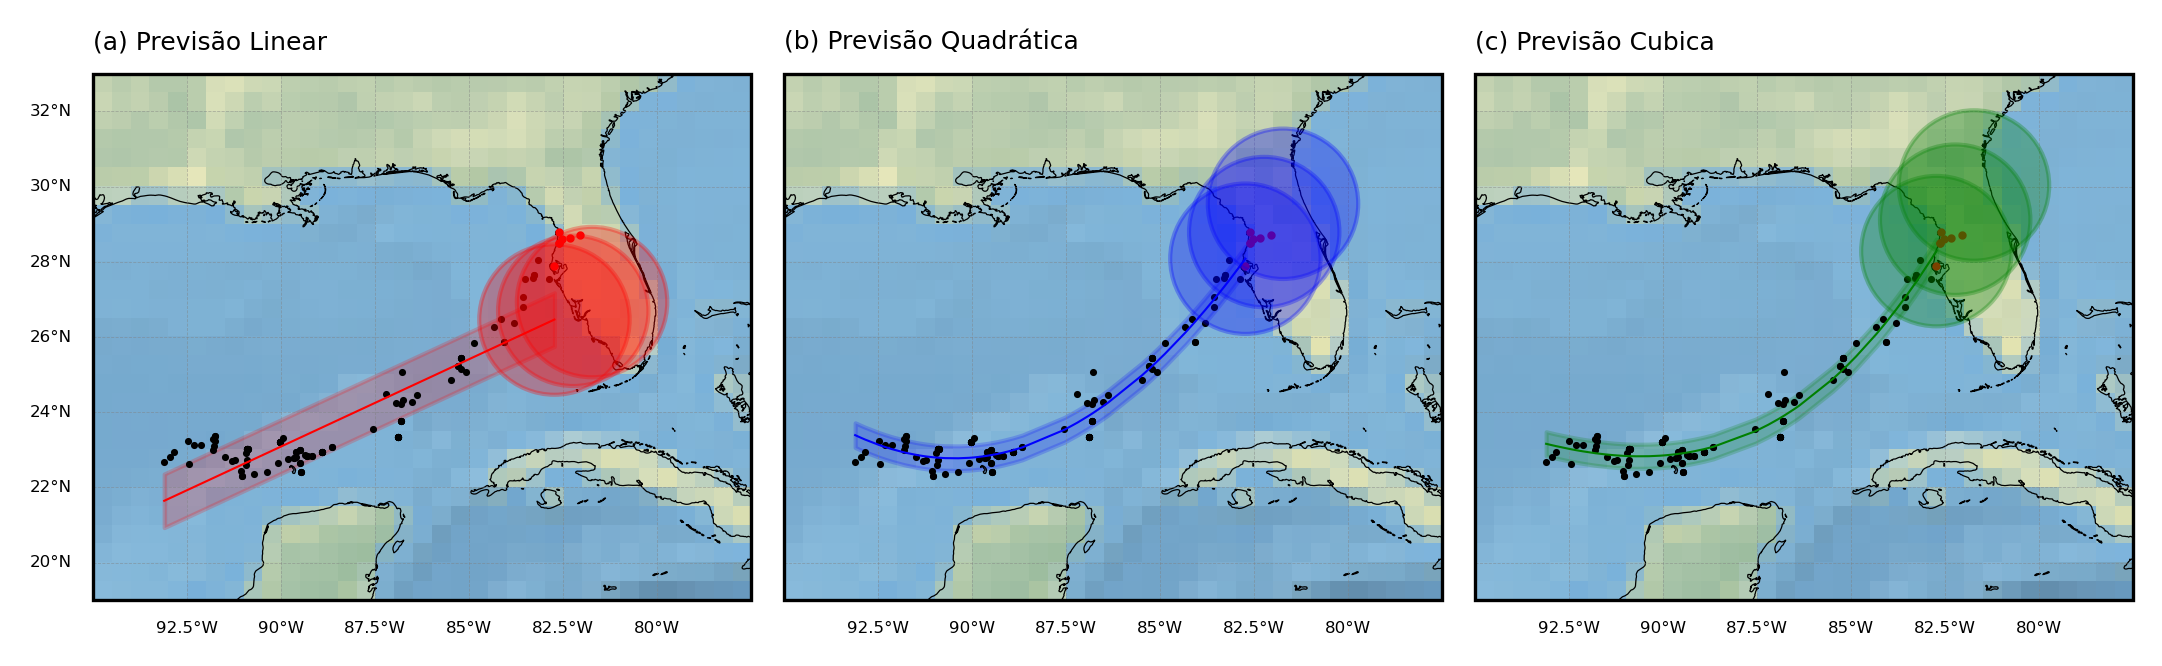

In [37]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.coastlines(linewidth=0.3)
ax1.set_extent([-95, -77.5, 19, 33],crs=proj)
ax1.stock_img()

ax1.scatter(DATA_TRAINING['lon_c'], DATA_TRAINING['lat_c'], s=0.5, color='k', zorder=6)
ax1.scatter(DATA_VALIDATION['lon_c'], DATA_VALIDATION['lat_c'], s=1, color='r', zorder=6)

ax1.plot(POS['x'].values, y_pred_linear, linewidth=0.5, color='r', label='Regresión lineal', zorder=6)

plt.fill_between(POS['x'].values, y_pred_linear - std_linear, y_pred_linear + std_linear,
                color='r', alpha=0.2, label='Incertidumbre lineal')

for nn in range(len(future)-1):
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_linear[nn]), radius=2, color='r', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title('(a) Previsão Linear', fontsize=6,loc='left')

# ==================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.coastlines(linewidth=0.3)
ax1.set_extent([-95, -77.5, 19, 33],crs=proj)
ax1.stock_img()

ax1.scatter(DATA_TRAINING['lon_c'], DATA_TRAINING['lat_c'], s=0.5, color='k', zorder=6)
ax1.scatter(DATA_VALIDATION['lon_c'], DATA_VALIDATION['lat_c'], s=1, color='r', zorder=6)

ax1.plot(POS['x'].values, y_pred_quadratic, linewidth=0.5, color='b', label='Regresión cuadrática', zorder=6)

plt.fill_between(POS['x'].values, y_pred_quadratic - std_quadratic, y_pred_quadratic + std_quadratic,
                color='b', alpha=0.2, label='Incertidumbre cuadrática')

for nn in range(len(future)-1):
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_quad[nn]), radius=2, color='b', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title('(b) Previsão Quadrática', fontsize=6,loc='left')

# ==================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.coastlines(linewidth=0.3)
ax1.set_extent([-95, -77.5, 19, 33],crs=proj)
ax1.stock_img()

ax1.scatter(DATA_TRAINING['lon_c'], DATA_TRAINING['lat_c'], s=0.5, color='k', zorder=6)
ax1.scatter(DATA_VALIDATION['lon_c'], DATA_VALIDATION['lat_c'], s=1, color='r', zorder=6)

ax1.plot(POS['x'].values, y_pred_cubic, linewidth=0.5, color='g', label='Regresión cúbica', zorder=6)

plt.fill_between(POS['x'].values, y_pred_cubic - std_cubic, y_pred_cubic + std_cubic,
                color='g', alpha=0.2, label='Incertidumbre cúbica')

for nn in range(len(future)-1):
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_cubic[nn]), radius=2, color='g', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title('(c) Previsão Cubica', fontsize=6,loc='left')

# ==================================================================================
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.05, wspace=0.05)

fig_out = f'../fig/previsao_all.png'
plt.savefig(fig_out, facecolor='white',bbox_inches ='tight',pad_inches = 0.1)

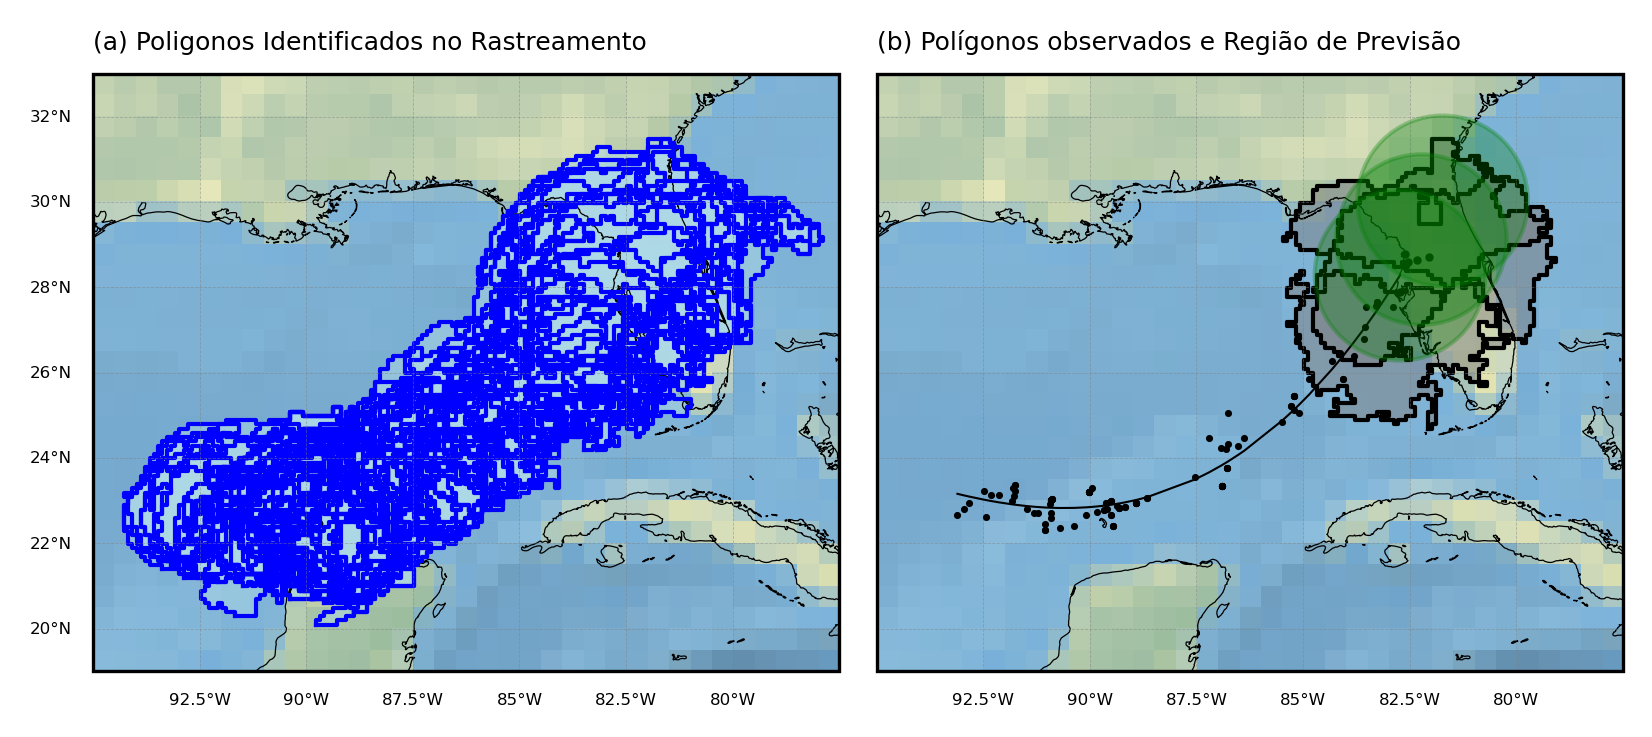

In [69]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.coastlines(linewidth=0.3)
ax1.set_extent([-95, -77.5, 19, 33],crs=proj)
ax1.stock_img()

for nn in np.arange(0,len(DATA_TRAINING),2):
    polygon = loads(DATA_TRAINING['geometry'][nn])
    x, y = polygon.exterior.xy
    ax1.plot(x, y, color='blue', linewidth=1)
    plt.fill(x, y, color='lightblue', alpha=0.5)

for nn in range(len(DATA_VALIDATION)):
    polygon = loads(DATA_VALIDATION['geometry'][nn])
    x, y = polygon.exterior.xy
    ax1.plot(x, y, color='blue', linewidth=1)
    plt.fill(x, y, color='lightblue', alpha=0.5)

ax1.set_title('(a) Poligonos Identificados no Rastreamento', fontsize=6,loc='left')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

# ==================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.coastlines(linewidth=0.3)
ax1.set_extent([-95, -77.5, 19, 33],crs=proj)
ax1.stock_img()

polygon = loads(DATA_TRAINING['geometry'][len(DATA_TRAINING)-1])
x, y = polygon.exterior.xy
ax1.plot(x, y, color='k', linewidth=1)
plt.fill(x, y, color='grey', alpha=0.5)

polygon = loads(DATA_VALIDATION['geometry'][len(DATA_VALIDATION)-1])
x, y = polygon.exterior.xy
ax1.plot(x, y, color='k', linewidth=1)
plt.fill(x, y, color='grey', alpha=0.5)

for nn in range(len(future)-1):
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_cubic[nn]), radius=2, color='g', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))

ax1.scatter(DATA_TRAINING['lon_c'], DATA_TRAINING['lat_c'], s=0.5, color='k', zorder=6)
ax1.scatter(DATA_VALIDATION['lon_c'], DATA_VALIDATION['lat_c'], s=1, color='k', zorder=6)
ax1.plot(POS['x'].values, y_pred_cubic, linewidth=0.5, color='k', zorder=6)

ax1.set_title('(b) Polígonos observados e Região de Previsão', fontsize=6,loc='left')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

# ==================================================================================
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.05, wspace=0.05)

fig_out = f'../../output/figures/previsao_finish.png'
plt.savefig(fig_out, facecolor='white',bbox_inches ='tight',pad_inches = 0.1)

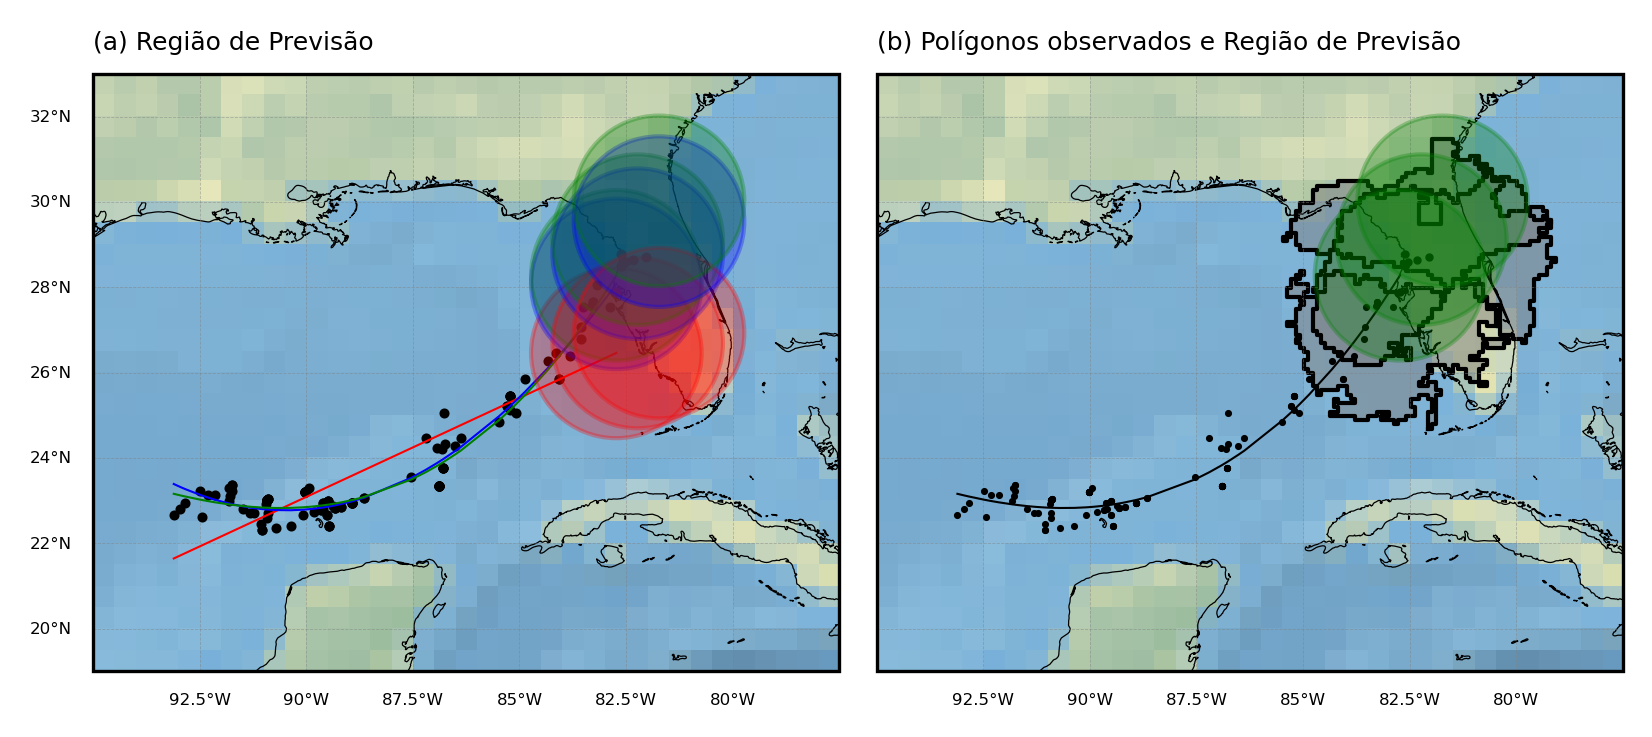

In [77]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.coastlines(linewidth=0.3)
ax1.set_extent([-95, -77.5, 19, 33],crs=proj)
ax1.stock_img()

ax1.scatter(DATA_TRAINING['lon_c'].values, DATA_TRAINING['lat_c'].values, color='k', s=2, label='Centroides de Treinamento', zorder=5)
ax1.scatter(DATA_VALIDATION['lon_c'].values, DATA_VALIDATION['lat_c'].values, color='r', s=2, label='Centroides de Validação', zorder=5)

for nn in range(len(future)-1):
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_linear[nn]), radius=2, color='r', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_quad[nn]), radius=2, color='b', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_cubic[nn]), radius=2, color='g', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))


ax1.plot(POS['x'].values, y_pred_linear, linewidth=0.5, color='r', label='Regresión lineal', zorder=6)
ax1.plot(POS['x'].values, y_pred_quadratic, linewidth=0.5, color='b', label='Regresión cuadrática', zorder=6)
ax1.plot(POS['x'].values, y_pred_cubic, linewidth=0.5, color='g', label='Regresión cúbica', zorder=6)

ax1.set_title('(a) Região de Previsão', fontsize=6,loc='left')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

# ==================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.coastlines(linewidth=0.3)
ax1.set_extent([-95, -77.5, 19, 33],crs=proj)
ax1.stock_img()

polygon = loads(DATA_TRAINING['geometry'][len(DATA_TRAINING)-1])
x, y = polygon.exterior.xy
ax1.plot(x, y, color='k', linewidth=1)
plt.fill(x, y, color='grey', alpha=0.5)

polygon = loads(DATA_VALIDATION['geometry'][len(DATA_VALIDATION)-1])
x, y = polygon.exterior.xy
ax1.plot(x, y, color='k', linewidth=1)
plt.fill(x, y, color='grey', alpha=0.5)

for nn in range(len(future)-1):
    # ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_quad[nn]), radius=2, color='b', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))
    ax1.add_patch(mpatches.Circle(xy=(future[nn], y_pred_future_cubic[nn]), radius=2, color='g', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))

ax1.scatter(DATA_TRAINING['lon_c'], DATA_TRAINING['lat_c'], s=0.5, color='k', zorder=6)
ax1.scatter(DATA_VALIDATION['lon_c'], DATA_VALIDATION['lat_c'], s=1, color='k', zorder=6)
ax1.plot(POS['x'].values, y_pred_cubic, linewidth=0.5, color='k', zorder=6)

ax1.set_title('(b) Polígonos observados e Região de Previsão', fontsize=6,loc='left')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

# ==================================================================================
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.05, wspace=0.05)

fig_out = f'../../output/figures/previsao_finish.png'
plt.savefig(fig_out, facecolor='white',bbox_inches ='tight',pad_inches = 0.1)